# Project 6: Solving Markov Decision Processes with Value Iteration

## Introduction

In this project, you will learn about **Markov Decision Processes (MDPs)**, one of the fundamental models in artificial intelligence for decision-making under uncertainty.  
You will implement **Value Iteration**, a classic dynamic programming algorithm for solving MDPs.

This project will guide you step-by-step through:
- Setting up an MDP environment
- Implementing Value Iteration
- Extracting the optimal policy
- Running and visualizing your results

You are expected to fill in each **TODO** where indicated.


## 1. MDP Basics and Setup

An MDP is defined by:
- A set of states **S**
- A set of actions **A**
- A transition probability function **P(s' | s, a)**
- A reward function **R(s, a, s')**
- A discount factor **gamma (γ)**

The goal is to find an **optimal policy** π\* that maximizes expected cumulative rewards.

## 1.1 Our Gridworld Environment

To make the concepts of MDPs concrete, we will work with a **6×6 Gridworld** environment.

The environment includes:
- **🏁 Terminal State**: (5,5) — reaching this state yields a large positive reward (+10).
- **🧱 Walls**: Some cells are blocked and cannot be entered.
- **💀 Traps**: Certain states (like (3,2) and (4,4)) carry severe penalties (-5 or -10) if the agent moves into them.
- **💎 Mini Bonuses**: Other states (like (1,5)) offer small positive rewards (+3), tempting the agent to detour.
- **⬜ Empty Cells**: Normal grid cells, with a small step penalty (-1) for moving through them.

Additionally:
- **Actions are stochastic**: Intended moves succeed 60% of the time, while 20% of the time the agent "slips" perpendicularly to the intended direction by mistake.
- **Obstacles must be navigated carefully**, because risky moves could accidentally slip the agent into traps.

### Why This Environment?

This world was carefully designed to teach key ideas of MDP planning:
- **Tradeoffs**: The agent must decide between faster but riskier paths and longer safer routes. Every step is penalized with a reward of -1, so agents are encouraged to find the fastest path to the goal. However, the gridworld is intentionally designed such that the fastest path is littered with obstacles and traps, making that path dangerous and incentivizing agents to take longer routes. 
- **Uncertainty**: Actions are not guaranteed, so planning must account for the possibility of slipping.
- **Reward Optimization**: Sometimes detouring for small bonuses can be optimal, depending on their location and reward magnitude.
- **Strategic Decision-Making**: Simply following the shortest path is no longer always the best strategy.

By solving this Gridworld using **Value Iteration**, you will experience firsthand how agents make optimal decisions in complex, uncertain environments.


In [1]:
# Setup: Define a simple Gridworld MDP
import numpy as np

class GridworldMDP:
    def __init__(self, grid_size=(6,7), terminal_states=[(5,6)], walls=[(1,1), (4,3)], traps={(1, 2): -10 ,(3, 2): -10,(4, 4): -10,(5, 4): -10}, mini_bonuses={(1, 5): 3}, gamma=0.9):
        self.grid_size = grid_size
        self.terminal_states = terminal_states
        self.walls = walls
        self.traps = traps
        self.mini_bonuses = mini_bonuses
        self.gamma = gamma
        self.actions = ['up', 'down', 'left', 'right']
        self.states = [(i, j) for i in range(grid_size[0]) for j in range(grid_size[1])]
        
    def get_actions(self, state):
        if state in self.terminal_states or state in self.walls:
            return []
        return self.actions

    def get_next_state(self, state, action):
        if state in self.terminal_states:
            return state
        
        i, j = state
        if action == 'up':
            i = max(i-1, 0)
        elif action == 'down':
            i = min(i+1, self.grid_size[0]-1)
        elif action == 'left':
            j = max(j-1, 0)
        elif action == 'right':
            j = min(j+1, self.grid_size[1]-1)
        
        next_state = (i, j)
        
        if next_state in self.walls:
            return state  # Can't move into a wall, stay in the same place
        return next_state

    def get_transition_probs(self, state, action):
        """Returns a list of (next_state, probability) pairs."""
        if state in self.terminal_states or state in self.walls:
            return [(state, 1.0)]

        intended = action
        perpendicular = {
            'up': ['left', 'right'],
            'down': ['left', 'right'],
            'left': ['up', 'down'],
            'right': ['up', 'down'],
        }
        
        probs = [
            (self.get_next_state(state, intended), 0.6),
            (self.get_next_state(state, perpendicular[action][0]), 0.2),
            (self.get_next_state(state, perpendicular[action][1]), 0.2),
        ]
        
        return probs

    def get_reward(self, state, action, next_state):
        if next_state in self.terminal_states:
            return 10 # Reward for reaching the terminal state
        elif next_state in self.traps.keys():
            return self.traps[next_state] # Penalty for falling into a trap
        elif next_state in self.mini_bonuses.keys():
            return self.mini_bonuses[next_state] # Bonus for reaching a mini bonus
        else:
            return -1 # Default step penalty
        
    def print_gridworld(mdp):
        """
        Prints the Gridworld layout showing walls, traps, mini bonuses, and goal states.
        """
        grid = []
        for i in range(mdp.grid_size[0]):
            row = []
            for j in range(mdp.grid_size[1]):
                pos = (i, j)
                if pos in mdp.walls:
                    row.append('🧱')  # Wall
                elif pos in mdp.terminal_states:
                    row.append('🏁')  # Goal (terminal state)
                elif pos in mdp.traps.keys():
                    row.append('💀')  # Trap (negative reward)
                elif pos in mdp.mini_bonuses.keys():
                    row.append('💎')  # Mini bonus (small positive reward)
                else:
                    row.append('⬜')  # Empty space
            grid.append(row)
        
        # Pretty print the grid
        for row in grid:
            print(' '.join(row))
        

mdp = GridworldMDP()
mdp.print_gridworld()

⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜
⬜ 🧱 💀 ⬜ ⬜ 💎 ⬜
⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜
⬜ ⬜ 💀 ⬜ ⬜ ⬜ ⬜
⬜ ⬜ ⬜ 🧱 💀 ⬜ ⬜
⬜ ⬜ ⬜ ⬜ 💀 ⬜ 🏁


In [2]:
# Setup: Print the Policy Nicely
def print_policy(policy, grid_size, walls):
    arrow_map = {
        'up': '⬆️', 'down': '⬇️', 'left': '⬅️', 'right': '➡️', 
        None: '🚫'
    }
    
    for i in range(grid_size[0]):
        row = ''
        for j in range(grid_size[1]):
            if (i,j) in walls:
                row += '🧱 '
            else:
                row += arrow_map[policy.get((i,j), None)] + ' '
        print(row)

# 2. Value Iteration Overview

Value Iteration works by repeatedly updating the value of each state using the Bellman optimality equation:

```math
V(s) = \max_a \sum_{s'} P(s'|s,a) [R(s,a,s') + \gamma V(s')]
```

In our simple Gridworld:
- Assume transitions are **deterministic**: each action deterministically moves the agent.
- Reward is **-1** for each move, and **0** if at a terminal state.


In [3]:
# 2.1. TODO: Initialize the Value Table
# Create a dictionary mapping each state to a value (start with zero)

# YOUR CODE HERE

V = {s: 0 for s in mdp.states}

# 3. Implementing Value Iteration

At each iteration:
- For every state:
  - Look at all possible actions
  - Calculate expected value of each action
  - Take the maximum value
- Stop when the change is below a small threshold (convergence).

In [4]:
# 3.1. TODO: Implement Value Iteration

def value_iteration(mdp, V, epsilon=1e-4):
    """
    Value Iteration algorithm to compute the optimal value function.
    Args:
        mdp: The MDP object.
        V: Initial value function.
        epsilon: Convergence threshold.
    Returns:
        V: The optimal value function.
    """
    
    while True:
        delta = 0
        new_V = {}
        
        for state in mdp.states:
            if state in mdp.terminal_states or state in mdp.walls:
                new_V[state] = 0
                continue
            
            action_values = []
            for action in mdp.get_actions(state):
                val = 0
                for next_state, prob in mdp.get_transition_probs(state, action):
                    reward = mdp.get_reward(state, action, next_state)
                    val += prob * (reward + mdp.gamma * V[next_state])
                action_values.append(val)
            
            best_action_value = max(action_values)
            new_V[state] = best_action_value
            
            delta = max(delta, abs(V[state] - new_V[state]))
        
        V = new_V
        
        if delta < epsilon:
            break
    
    return V

# Run it
V = value_iteration(mdp, V)


# 4. Extract the Optimal Policy

Once you have the Value function V, you can extract the optimal policy by:
- For each state:
  - Choose the action that leads to the best expected value.

In [5]:
# 4.1. TODO: Implement Policy Extraction

def extract_policy(mdp, V):
    """
    Extracts the policy from the value function.
    Args:
        mdp: The MDP object.
        V: The value function.
    Returns:
        policy: A dictionary mapping states to actions.
    """
    policy = {}
    
    for state in mdp.states:
        if state in mdp.terminal_states or state in mdp.walls:
            policy[state] = None
            continue
        
        best_action = None
        best_value = -np.inf
        
        for action in mdp.get_actions(state):
            val = 0
            for next_state, prob in mdp.get_transition_probs(state, action):
                reward = mdp.get_reward(state, action, next_state)
                val += prob * (reward + mdp.gamma * V[next_state])
            
            if val > best_value:
                best_value = val
                best_action = action
        
        policy[state] = best_action
    
    return policy

policy = extract_policy(mdp, V)

## 5. Print the Policy

In [6]:
# TODO: Print the gridworld again (for comparison) and policy nicely (use the provided print_policy function)
mdp.print_gridworld()
print("\n")
print_policy(policy, mdp.grid_size, mdp.walls)

⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜
⬜ 🧱 💀 ⬜ ⬜ 💎 ⬜
⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜
⬜ ⬜ 💀 ⬜ ⬜ ⬜ ⬜
⬜ ⬜ ⬜ 🧱 💀 ⬜ ⬜
⬜ ⬜ ⬜ ⬜ 💀 ⬜ 🏁


➡️ ➡️ ➡️ ➡️ ➡️ ⬇️ ⬇️ 
⬆️ 🧱 ➡️ ➡️ ➡️ ➡️ ⬅️ 
⬆️ ➡️ ➡️ ➡️ ➡️ ⬆️ ⬇️ 
⬆️ ⬅️ ➡️ ➡️ ⬆️ ➡️ ⬇️ 
⬆️ ⬆️ ⬇️ 🧱 ➡️ ➡️ ⬇️ 
⬆️ ⬆️ ⬅️ ⬅️ ➡️ ➡️ 🚫 


## 6. Explain Your Learned Policy (Short Answer)

After running value iteration and extracting the optimal policy, you should observe interesting patterns in the agent’s behavior.

**Question:**  
- In your own words, explain the key decisions the agent makes when navigating the Gridworld.
- Specifically, why does the agent sometimes avoid certain paths even if they seem direct?
- Why might the agent sometimes go out of its way to collect the mini bonus, and other times ignore it?

Write 4–6 sentences interpreting the learned policy based on the layout of traps, mini bonuses, and transition uncertainty.

### TODO: Analyze your learned policy

The agent's learned policy shows sophisticated strategic behavior.  
When starting from the far left side of the grid, the agent avoids cutting through the narrow gap between nearby traps because the risk of accidentally slipping into a trap is too high. Instead, it detours upwards to take a safer, although longer, path toward the goal. This path also eventually ends up passing right over the mini bonus without needing a detour, providing further incentive to take the upward route. However, when the agent is already closer to the gap (in the second or third columns), it sometimes risks passing between the traps, because the extra cost of a full detour would outweigh the risk. )

Regarding the mini bonus, the agent chooses to collect it if doing so is relatively easy and does not significantly delay reaching the goal. Otherwise, when already close to the goal or when detouring would be too costly, the agent skips the bonus and proceeds directly.  
Thus, the policy reflects careful risk vs reward tradeoffs based on the agent’s current position and proximity to hazards and incentives.

##  Bonus 1: Plotting Value Iteration Convergence (Optional)

During Value Iteration, the value function gradually stabilizes as updates become smaller and smaller.

**Task:**  
- Modify your `value_iteration` function to **record** the maximum change (delta) at each iteration.
- After Value Iteration finishes, **plot delta vs iteration number** using `matplotlib`.

**Goal:**  
You should observe that delta decreases over time, ideally exponentially, as the value function converges.

**Hint:**  
- Plot the convergance on a log scale for better visability


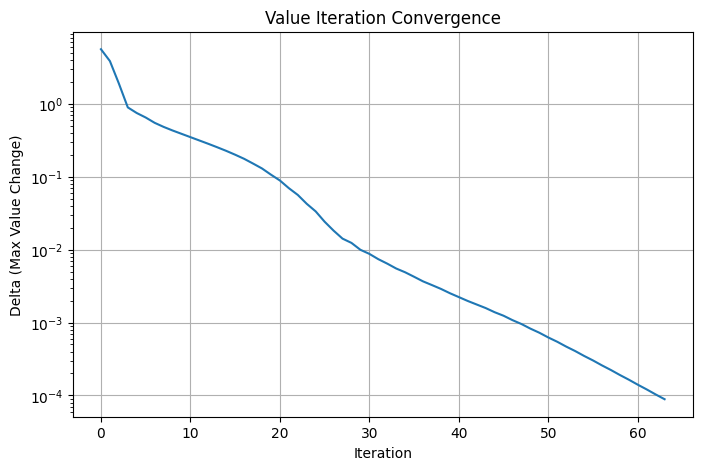

In [7]:
# BONUS 1 TODO: Plot the convergence of the value function

import matplotlib.pyplot as plt

def value_iteration(mdp, V, epsilon=1e-4):
    """
    Value Iteration algorithm that records convergence statistics.
    """
    deltas = []  # List to store the maximum delta at each iteration
    
    while True:
        delta = 0
        new_V = {}
        
        for state in mdp.states:
            if state in mdp.terminal_states or state in mdp.walls:
                new_V[state] = 0
                continue
            
            action_values = []
            for action in mdp.get_actions(state):
                val = 0
                for next_state, prob in mdp.get_transition_probs(state, action):
                    reward = mdp.get_reward(state, action, next_state)
                    val += prob * (reward + mdp.gamma * V[next_state])
                action_values.append(val)
            
            best_action_value = max(action_values)
            new_V[state] = best_action_value
            
            delta = max(delta, abs(V[state] - new_V[state]))
        
        deltas.append(delta)
        V = new_V
        
        if delta < epsilon:
            break
    
    return V, deltas

# New Gridworld MDP
mdp = GridworldMDP()

# Initialize the Value Table
V = {s: 0 for s in mdp.states}

# Run
V, deltas = value_iteration(mdp, V)

# Plotting the convergence
plt.figure(figsize=(8, 5))
plt.plot(deltas)
plt.yscale('log')  # Log scale for better visibility
plt.xlabel('Iteration')
plt.ylabel('Delta (Max Value Change)')
plt.title('Value Iteration Convergence')
plt.grid(True)
plt.show()

## Bonus 2: How Does Discount Factor (γ) Affect Convergence? (Optional)

The discount factor **γ** controls how much the agent values future rewards compared to immediate rewards.

**Task:**  
- Try re-running your Value Iteration with different values of γ:
  - γ = 0.5
  - γ = 0.9 (default)
  - γ = 0.99
- For each γ, plot the delta vs iteration curve as you did before.

**Questions to Think About:**
- How does the value of γ affect the number of iterations needed for convergence?
- Why do higher γ values tend to require more iterations?
- What does this tell you about agents that prioritize long-term rewards versus short-term gains?

**Goal:**  
Understand how **temporal horizon** (how far into the future the agent plans) affects the speed and difficulty of finding optimal policies.

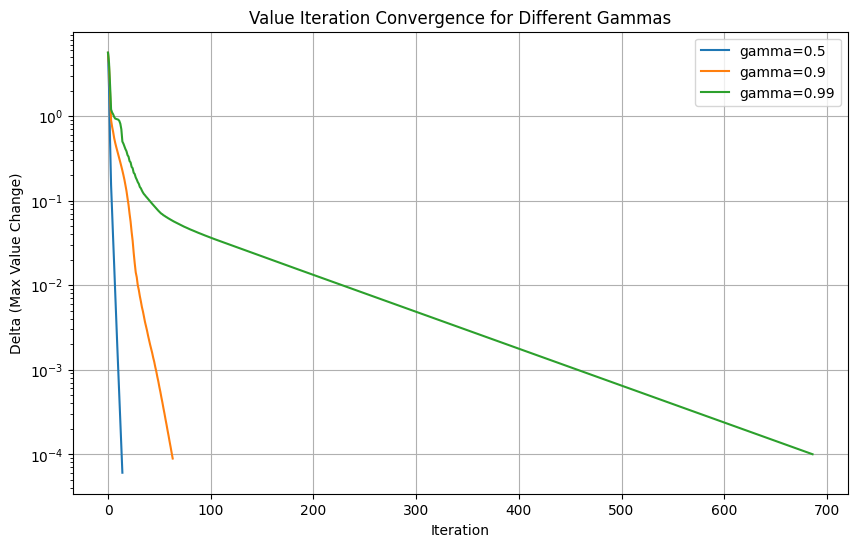

In [8]:
# Bonus 2 TODO: Compare convergence for different discount factors

gammas = [0.5, 0.9, 0.99]
plt.figure(figsize=(10,6))

for gamma in gammas:
    # Create new MDP with different gamma
    mdp = GridworldMDP(gamma=gamma)
    V = {s: 0 for s in mdp.states}
    V, deltas = value_iteration(mdp, V)
    plt.plot(deltas, label=f'gamma={gamma}')

plt.yscale('log')  # Log scale for better visibility
plt.xlabel('Iteration')
plt.ylabel('Delta (Max Value Change)')
plt.title('Value Iteration Convergence for Different Gammas')
plt.legend()
plt.grid(True)
plt.show()

### Bonus 2 TODO: Provide a Brief Explanation of Your Graph

The graph shows how the discount factor γ affects the convergence speed of Value Iteration.  
We observe that:

- **γ = 0.5** converges very quickly (around 20 iterations) because the agent heavily discounts future rewards and focuses on immediate outcomes.
- **γ = 0.9** requires more iterations (around 65) as the agent considers longer-term rewards, leading to slower value stabilization.
- **γ = 0.99** converges very slowly (around 680 iterations) since the agent values future rewards almost equally with immediate ones, causing value updates to propagate across the entire state space over many iterations.

This behavior is expected: as γ approaches 1, Value Iteration slows down because small changes ripple through more distant future states.  
In general, convergence speed is inversely related to (1−γ).